In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from PIL import Image
from pathlib import Path
import torch 
from util import box_ops
from datasets import transforms as T
from datasets.argoversehd import ArgoverseHDDataset

import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


plt.rcParams["figure.figsize"] = (25,5)
number_of_colors = 91
class_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

In [2]:
def clip_data(a):
    '''
    a: torch.tensor
    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats
    '''
    a_min = a.min()
    a_max = a.max()
    return torch.clip((a-a_min)/torch.abs(a_max-a_min),0,1)

In [3]:
def rescale_boxes(out_bbox,im_size):
    '''
    for one image
    '''
    # convert to [x0, y0, x1, y1] format
    boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
    # and from relative [0, 1] to absolute [0, height] coordinates
    img_h, img_w = im_size
    scale_fct = torch.tensor([img_w, img_h, img_w, img_h])
    boxes = boxes * scale_fct
    return boxes

In [4]:
def plotTarget(target, im_size=None, ax=None, rescale=True):
    """
    Display the specified annotations.
    :param target (dict)
    :return: None
    """
    
    ax = ax if ax else plt.gca()
    ax.set_autoscale_on(False)

    boxes = rescale_boxes(target['boxes'], im_size) if rescale else target['boxes']
    polygons = []
    color = []
    for i in range(len(boxes)):
        c = class_color[target['labels'][i]]
        [bbox_x, bbox_y, bbox_x2, bbox_y2] = boxes[i]
        poly = [[bbox_x, bbox_y], [bbox_x, bbox_y2], [bbox_x2, bbox_y2], [bbox_x2, bbox_y]]
        np_poly = np.array(poly).reshape((4,2))
        polygons.append(Polygon(np_poly))
        color.append(c)
    
    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

In [5]:
def make_coco_transforms(image_set):

    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) # TODO:

    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768]

    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomResize(scales, max_size=800),
            T.PhotometricDistort(),
            T.Compose([
                     T.RandomResize([400, 500, 600]),
                     T.RandomSizeCrop(384, 600),
                     # To suit the GPU memory the scale might be different
                     T.RandomResize([300], max_size=540),#for r50
                     #T.RandomResize([280], max_size=504),#for r101
            ]),
            normalize,
        ])
        # return T.Compose([T.RandomResize([500], max_size=540), T.ToTensor()])

    if image_set == 'val':
        return T.Compose([
            T.RandomResize([360], max_size=640),
            normalize,
        ])
        # return T.Compose([T.RandomResize([500], max_size=540), T.ToTensor()])

    raise ValueError(f'unknown {image_set}')

In [6]:
root = Path('/nobackup/yb/Argoverse')
image_set = 'train'

PATHS = {
        "train": (root / "Argoverse-1.1/tracking" / "train", root / "Argoverse-HD/annotations" / "train.json"),
        "val": (root / "Argoverse-1.1/tracking" / "val", root / "Argoverse-HD/annotations" / "val.json")
}

data_dir, json_file = PATHS[image_set]
dataset = ArgoverseHDDataset(data_dir, json_file, transforms=make_coco_transforms(image_set), num_frames = 1, future=False)
print(image_set, ' ',dataset.__len__(), ' measurements')

loading annotations into memory...
Done (t=3.47s)
creating index...
index created!
train   19669  measurements


In [7]:
from torch.utils.data import DataLoader
import util.misc as utils

In [8]:
# sampled the dataset to speed up trainning for debuging
sampled_indices = random.sample(list(range(len(dataset))),len(dataset))[:500]
dataset = torch.utils.data.Subset(dataset,sampled_indices)

# subsampling the dataset
sampler_train = torch.utils.data.RandomSampler(dataset)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, batch_size=2, drop_last=True)

data_loader_train = DataLoader(dataset, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=2)

In [9]:
nestedtensor, targets = next(iter(data_loader_train))
samples = nestedtensor.tensors

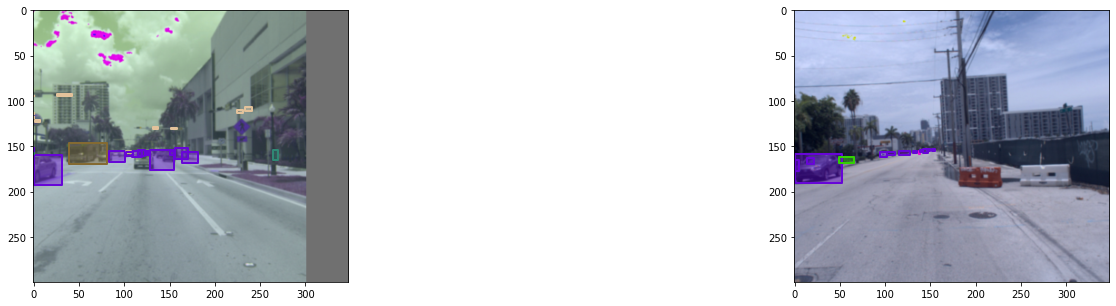

In [10]:
batch_size = len(targets)
fig, axes = plt.subplots(1,batch_size)

for i in range(batch_size):
    sample = clip_data(samples[i])
    target = targets[i]
    ax = axes[i]

    im = sample.numpy().transpose((1,2,0))
    ax.imshow(im)
    plotTarget(target,im.shape[:2],ax)

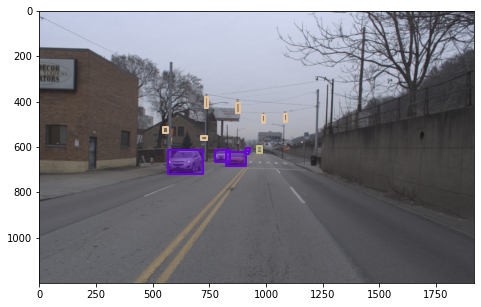

In [11]:
# num_frame = 1, current
# *1 before augmentation
t = torch.load('argoverse_before_trans.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0])
plotTarget(target,rescale=False)

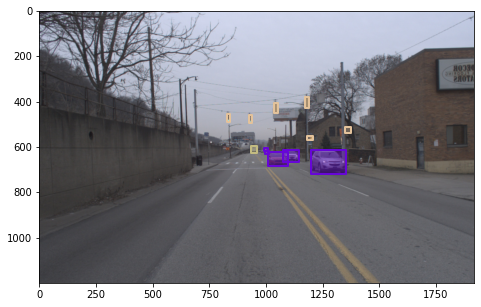

In [12]:
# *2 hclip
t = torch.load('argoverse_hfip.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0])
plotTarget(target,rescale=False)

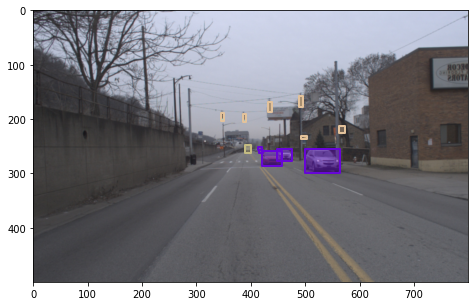

In [13]:
# *3 resize
t = torch.load('argoverse_resize.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0])
plotTarget(target,rescale=False)

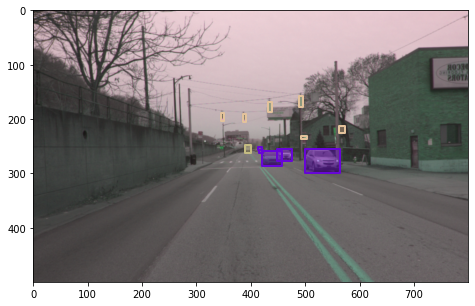

In [14]:
# *4 photometricDistort
t = torch.load('argoverse_photometricDistort.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0])
plotTarget(target,rescale=False)

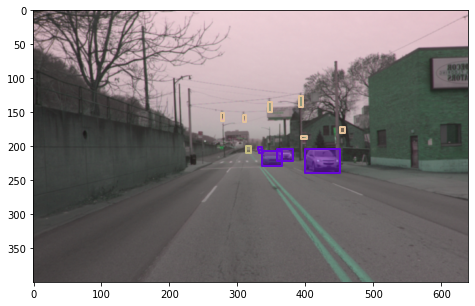

In [15]:
# *5 resize2
t = torch.load('argoverse_resize2.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0])
plotTarget(target,rescale=False)

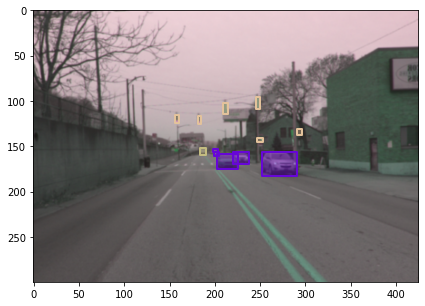

In [16]:
# *7 resize 3
t = torch.load('argoverse_resize3.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0])
plotTarget(target,rescale=False)

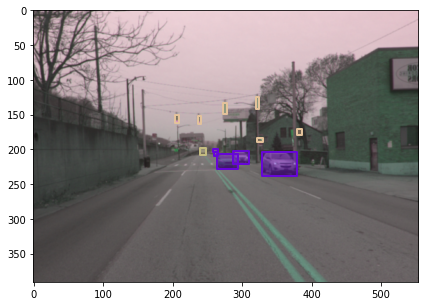

In [17]:
# *6 crop
t = torch.load('argoverse_crop.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0])
plotTarget(target,rescale=False)

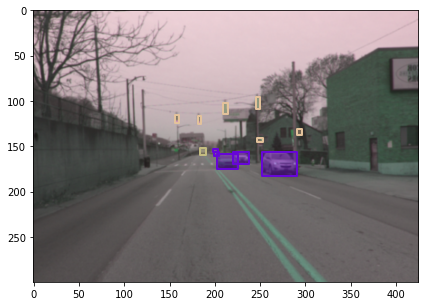

In [18]:
# *8 to tensor
t = torch.load('argoverse_to_tensor.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']

plt.imshow(imgs[0].numpy().transpose((1,2,0)))
plotTarget(target,rescale=False)

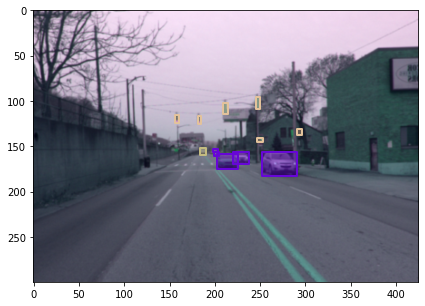

In [19]:
# *9 normalized
t = torch.load('argoverse_normalized.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']
im = clip_data(imgs[0]).numpy().transpose((1,2,0))
plt.imshow(im)
plotTarget(target,im.shape[:2])

In [20]:
im.shape

(300, 425, 3)

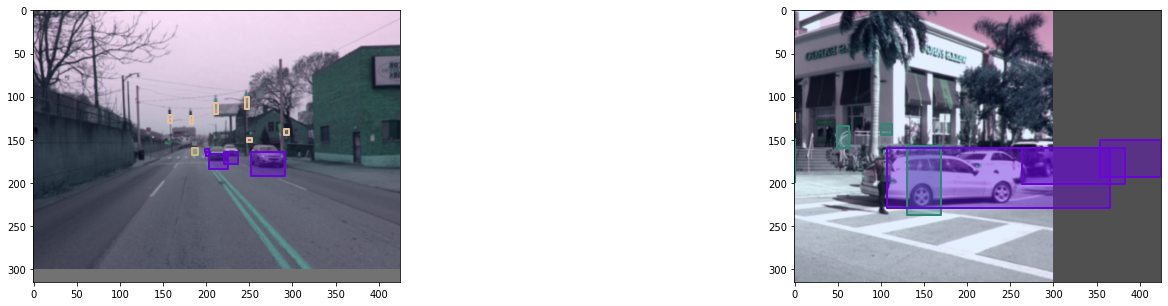

In [34]:
# before model
t = torch.load('argoverse_before_model.pth',map_location='cpu')

samples = t['imgs']
targets = t['targets']

batch_size = len(targets)
fig, axes = plt.subplots(1,batch_size)

for i in range(batch_size):
    sample = clip_data(samples[i])
    target = targets[i]
    ax = axes[i]

    im = sample.numpy().transpose((1,2,0))
    ax.imshow(im)
    plotTarget(target,im.shape[:2],ax) # im_size before pa

In [35]:
sample.shape

torch.Size([3, 315, 425])

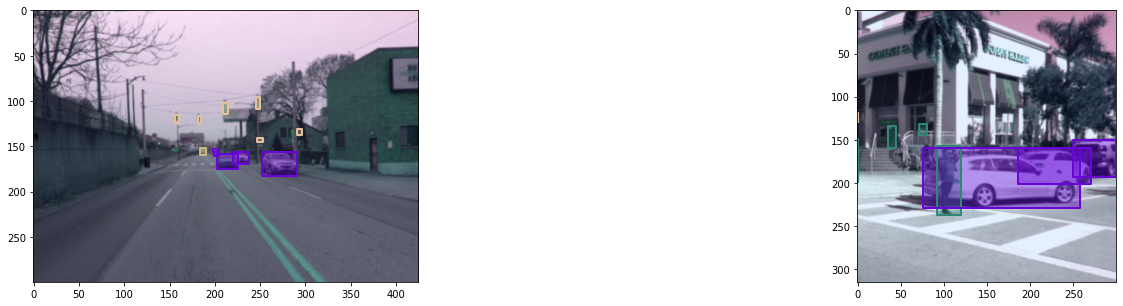

In [50]:
# before model with mask
t = torch.load('argoverse_beofre_model_w_masks.pth',map_location='cpu')

tensors, masks = t['imgs'].decompose()
targets = t['targets']

batch_size = len(targets)
fig, axes = plt.subplots(1,batch_size)

for i in range(batch_size):
    sample = clip_data(samples[i])
    mask = masks[i]
    target = targets[i]
    ax = axes[i]

    idx = torch.nonzero(~mask,as_tuple=True)
    oh,ow = idx[0].max()+1, idx[1].max()+1

    im = sample.numpy().transpose((1,2,0))
    ax.imshow(im[:oh,:ow])
    plotTarget(target,(oh,ow),ax) # im_size before pa

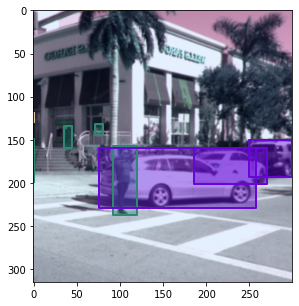

In [22]:
# after aug
t = torch.load('argoverse_after_aug_im2.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']
im = clip_data(imgs[0]).numpy().transpose((1,2,0))
plt.imshow(im)
plotTarget(target,im.shape[:2])

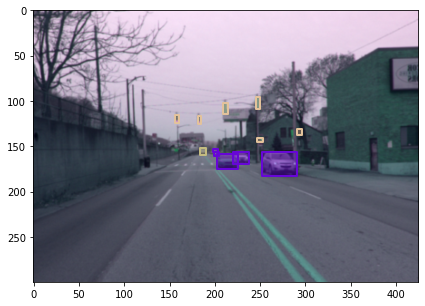

In [23]:
t = torch.load('argoverse_after_aug_im1.pth',map_location='cpu')
imgs = t['imgs']
target = t['targets']
im = clip_data(imgs[0]).numpy().transpose((1,2,0))
plt.imshow(im)
plotTarget(target,im.shape[:2])

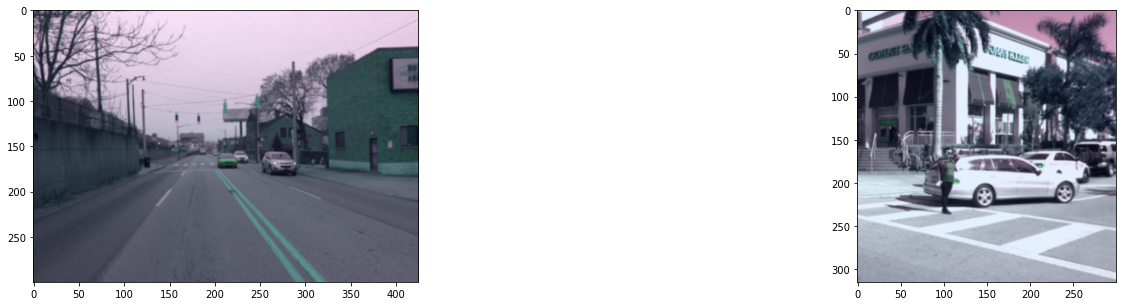

In [24]:
# before padding
t = torch.load('argoverse_before_padding.pth',map_location='cpu')

samples = t['imgs']
batch_size = len(samples)
fig, axes = plt.subplots(1,batch_size)

for i in range(batch_size):
    sample = clip_data(samples[i])
    ax = axes[i]

    im = sample.numpy().transpose((1,2,0))
    ax.imshow(im)